<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/shruti-working/zindi_airstrip_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [1]:
%%capture
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert
!pip -q install segmentation-models-pytorch

In [2]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import rasterio.mask
from shapely.geometry import box
from pyproj import Transformer

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms
import segmentation_models_pytorch as smp

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'zindi-amazon-secret-runway'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 270 (delta 46), reused 6 (delta 2), pack-reused 162 (from 1)
Receiving objects: 100% (270/270), 33.14 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (113/113), done.
fatal: not a git repository (or any of the parent directories): .git


## Set shared project folder on Google Drive
The satellite images for inference and model files stored in a shared folder `Zindi-Amazon` on Google Drive. To access the shared folder in Google Colab, first create a shortcut to the shared folder. Copy the shortcut to your Google Drive.

Now you can access `Zindi-Amazon` like any other folder in your Google Drive.

In [5]:
shared_path = '/content/drive/MyDrive/Zindi-Amazon/'

Create a `working` folder in Google Colab runtime for storing intermediate data products. This folder is deleted at the end of your session.

In [6]:
# Define the path for the new folder
working_path = '/content/working'

# Create the folder if it doesn't already exist
if not os.path.exists(working_path):
    os.makedirs(working_path)
    print(f"Folder created: {working_path}")
else:
    print(f"Folder already exists: {working_path}")

Folder created: /content/working


# Download AOI boundary & corresponding satellite image for inference


In [7]:
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'

In [98]:
aoi_name = '2021_04'

In [99]:
# Read data using GeoPandas
filename = os.path.join(base_aoi_path, f'aoi_{aoi_name}.shp')
aoiboundary = gpd.read_file(filename)
aoicrs = aoiboundary.crs
print("AOI CRS: {}".format(aoicrs))
aoiboundary

AOI CRS: EPSG:32718


,MINX,MINY,MAXX,MAXY,CNTX,CNTY,AREA,PERIM,HEIGHT,WIDTH,geometry
0,655519.352317,8.803686e+06,670929.352317,8.818956e+06,663224.352317,8.811321e+06,235310700.0,61360.0,15270.0,15410.0,"POLYGON ((655519.352 8803686.22, 655519.352 88..."


## Download inference image

Load and visualize the satellite raster image using the Rasterio library. The images in the `inference` folder have 9 bands from Sentinel1 and Sentinel2 satellites.

In [100]:
tif_file = os.path.join(shared_path + 'inference/', 'Sentinel_AllBands_Inference_{}.tif'.format(aoi_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = 'Sentinel_AllBands_Inference_{}.tif'.format(aoi_name)

with rasterio.open(tif_file) as src:
    # Loop through each band and print its name
    for i in range(1, src.count + 1):  # Bands are 1-indexed in rasterio
        band_description = src.descriptions[i - 1]  # Get the description of each band
        print(f"Band {i}: {band_description}")

Band 1: B4
Band 2: B3
Band 3: B2
Band 4: B8
Band 5: B11
Band 6: B12
Band 7: VV
Band 8: VH
Band 9: VV_VH_Ratio


## Create a new tif file containing subset of the bands

In [101]:
tif_file_subset = os.path.join(working_path, 'Sentinel_AllBands_Inference_{}_subset.tif'.format(aoi_name))

In [102]:
with rasterio.open(tif_file) as src:
    # Extract band indexes from descriptions and read directly
    bands = {'B4': None, 'B3': None, 'B2': None}
    for i, desc in enumerate(src.descriptions):
        if desc in bands:
            bands[desc] = src.read(i + 1)  # Read 1-based bands

    # Check if all required bands were found
    if any(value is None for value in bands.values()):
        raise ValueError(f"Not all bands found in image: {tif_file}")

    # Update metadata for the new file
    out_meta = src.meta.copy()
    out_meta.update({
        "count": 3  # Number of bands to save in the new file
    })

    # Stack the selected bands to form the final image array
    # Normalize values to match step in training
    # band_data = np.stack([np.clip(bands['B4'],0,2000)/2000,
    #                   np.clip(bands['B3'],0,2000)/2000,
    #                   np.clip(bands['B2'],0,2000)/2000], axis=-1)
    band_data = np.stack([np.clip(bands['B4'],0,2000),
                      np.clip(bands['B3'],0,2000),
                      np.clip(bands['B2'],0,2000)], axis=-1)

    band_data = np.moveaxis(band_data, -1, 0)  # Reorder to (bands, height, width)

    # Write the subset of bands to a new TIFF file
    with rasterio.open(tif_file_subset, "w", **out_meta) as dest:
        dest.write(band_data)

# New 3-band image ready for model inference
print(f"New TIFF file with selected bands created at: {tif_file_subset}")

New TIFF file with selected bands created at: /content/working/Sentinel_AllBands_Inference_2021_04_subset.tif


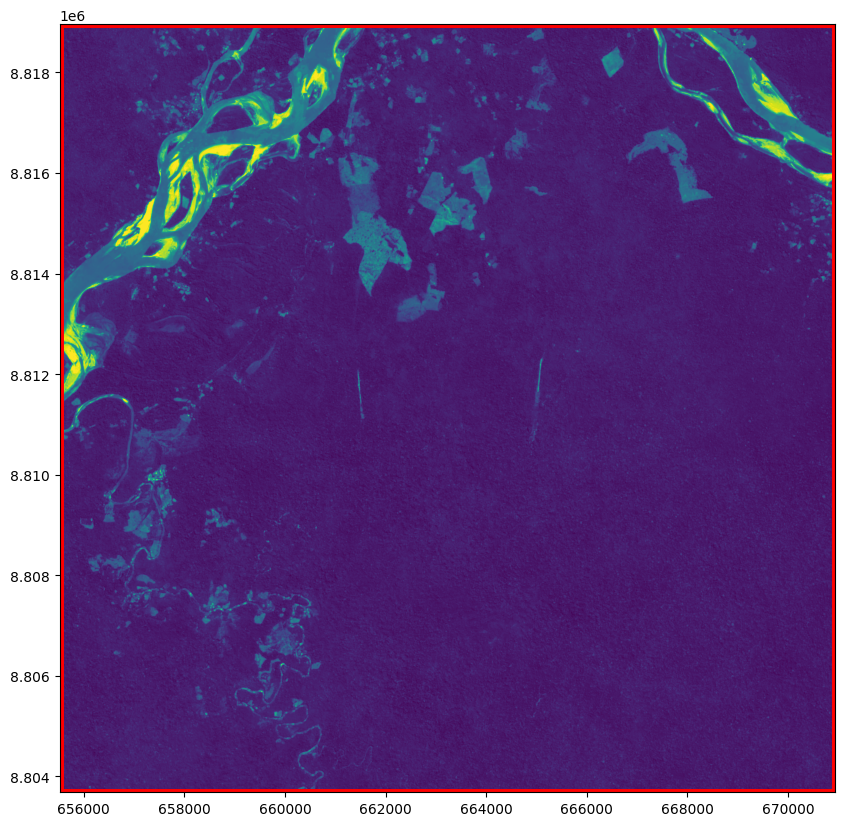

In [103]:
# Open image file using Rasterio
image = rio.open(tif_file_subset)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(10,10))
aoiboundary.plot(facecolor="none", linewidth=5, edgecolor='red', ax=ax)
show(image, ax=ax);

# Split the inference image into patches

During training, the model learned to recognize patterns within a specific patch size. Split the image up into same sized patches before running inference.

In [104]:
patch_size = 224

## Create tiles

In [105]:
def generate_tiles(image_file, output_file, area_str, size=224):
    """Generates square polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains square polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 224 x 224 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to AOI crs
    results.crs = {'init' : aoicrs}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of specified patch size across the satellite image.

In [106]:
output_patch_file = os.path.join(working_path, 'aoi_{}_{}x{}px_patches.geojson'.format(aoi_name, patch_size, patch_size))
tiles = generate_tiles(tif_file_subset, output_patch_file, aoi_name, size=224)

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/2353107 [00:00<?, ?it/s]

Data dimensions: (49, 2)


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,geometry
0,2021_04-0,"POLYGON ((657759.352 8816716.22, 657759.352 88..."
1,2021_04-1,"POLYGON ((659999.352 8816716.22, 659999.352 88..."
2,2021_04-2,"POLYGON ((662239.352 8816716.22, 662239.352 88..."


## Visualize tiles

Let's open the inference raster file using Rasterio and superimpose the tiles.

(8803276.22022452, 8818956.22022452)

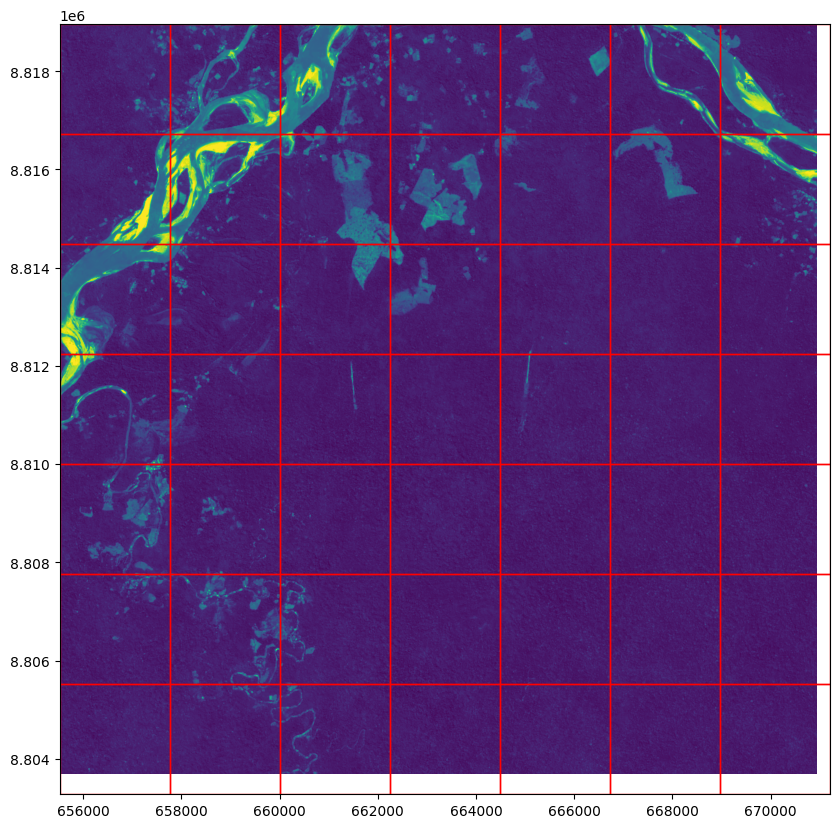

In [107]:
# Open image file using Rasterio
image = rio.open(tif_file_subset)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(10,10))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)

# Get the extent of the tiles
tiles_extent = tiles.total_bounds  # returns [minx, miny, maxx, maxy]

# Show the image and set plot limits based on tiles extent
show(image, ax=ax)
ax.set_xlim(tiles_extent[0], tiles_extent[2])  # Set x limits (minx, maxx)
ax.set_ylim(tiles_extent[1], tiles_extent[3])  # Set y limits (miny, maxy)

<a name="lulc-maps"></a>
# Inference
Generate airstrip prediction using a trained model.

## Crop inference image to patch size

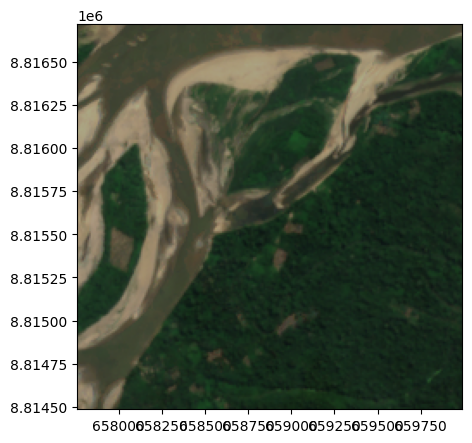

In [108]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]

      # Normalize the image for display (0-255 for uint8)
      out_image = np.clip(out_image, 0, 3000)  # Clip reflectance values to a max threshold
      out_image = (out_image / 3000 * 255).astype(np.uint8)  # Scale to 0-255

      # Visualize the cropped image with transform and title
      fig, ax = plt.subplots(figsize=(5, 5))
      show(out_image, transform=out_transform, ax=ax, title=title)
      plt.show()

show_crop(tif_file_subset, [tiles.iloc[8]['geometry']])

## Define data transformations

A set of data transformations to the test set were applied during training. Before running the inference images through the model, apply the same transformation to the inference image.

In [109]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((patch_size, patch_size)),  # Resize to match patch_size used in training
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Load trained model

In [110]:
model_name = 'zindi_best_model_20241028_50m_lr0005'
#model_name = 'zindi_best_model_20241028_100m_lr0005'

In [111]:
# UNet model with ResNet50 encoder
def get_model():
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=3,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = shared_path + 'models/' + model_name + '.pth'

model = get_model().to(device)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

<ipython-input-112-e8525ec37b50>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


Model file /content/drive/MyDrive/Zindi-Amazon/models/zindi_best_model_20241028_50m_lr0005.pth successfully loaded.


## Create a subfolder for model to store output

In [113]:
# Define the path for the new folder
model_output_path = working_path + '/' + model_name

# Create the folder if it doesn't already exist
if not os.path.exists(model_output_path):
    os.makedirs(model_output_path)
    print(f"Folder created: {model_output_path}")
else:
    print(f"Folder already exists: {model_output_path}")

Folder already exists: /content/working/zindi_best_model_20241028_50m_lr0005


## Run prediction for each image patch

In [114]:
def predict_airstrip(image, shape, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = os.path.join(working_path, 'temp.tif')
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model

        # Use Pillow to read raster image
        #image = Image.open(temp_tif)

        # Use rasterio to read the image instead of Pillow
        # to avoid UnidentifiedImageError(msg)
        with rio.open(temp_tif) as dataset:
            image_data = dataset.read()
            image_data = image_data.transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)

            # Convert the image data to a PIL Image
            image = Image.fromarray(image_data.astype(np.uint8)) #Ensure image data is of type uint8

        input = transform(image)

        # Get the model's output
        output = model(input.unsqueeze(0))

        # Apply sigmoid if necessary to get probabilities between 0 and 1
        output = torch.sigmoid(output) # Uncomment if model outputs logits instead of probabilities

        # Threshold to get binary predictions (0 or 1)
        predictions = (output > 0.5).int() # Adjust threshold if needed

        # Return the entire prediction tensor
        return predictions

    return None

Let's iterate over every tile and generate model predictions for the corresponding image patch. Overwriting each temporary TIFF file to save storage space.

In [115]:
# Commence model prediction
all_predictions = []  # Store predictions for all tiles
for index in tqdm(range(len(tiles)), total=len(tiles)):
    predictions = predict_airstrip(tif_file_subset, [tiles.iloc[index]['geometry']], model)
    all_predictions.append(predictions)

# Save predictions
filepath = os.path.join(f"{working_path}/{model_name}", "{}_preds.geojson".format(aoi_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

  0%|          | 0/49 [00:00<?, ?it/s]

,id,geometry
0,2021_04-0,"POLYGON ((657759.352 8816716.22, 657759.352 88..."
1,2021_04-1,"POLYGON ((659999.352 8816716.22, 659999.352 88..."
2,2021_04-2,"POLYGON ((662239.352 8816716.22, 662239.352 88..."


## Create a predictions raster

Process the predictions for each image patch and create a single band tif file for each tile.

In [116]:
# Process the predictions for each tile
for tile_index, predictions in enumerate(all_predictions):
    # Convert predictions to numpy array for easier processing
    predictions_np = predictions.squeeze().cpu().numpy()

    # Get tile geometry
    tile_geometry = tiles.iloc[tile_index]['geometry']

    # Create a new raster dataset with the same metadata as the input tile
    with rio.open(tif_file_subset) as src:
        profile = src.profile
        profile.update({
            'dtype': rio.uint8,  # Assuming predictions are 0 or 1
            'count': 1,  # Single band for predictions
            'height': predictions_np.shape[0],
            'width': predictions_np.shape[1]
        })

        # Save the predictions as a new GeoTIFF file
        output_file = os.path.join(f"{working_path}/{model_name}", f"aoitile_{aoi_name}_{tile_index}_predictions.tif")
        with rio.open(output_file, 'w', **profile) as dst:
            dst.write(predictions_np, 1)  # Write predictions to the first band

    # Update the tiles GeoDataFrame with the prediction file path
    tiles.loc[tile_index, 'prediction_file'] = output_file

Create a mosaic raster from all the predictions tif files

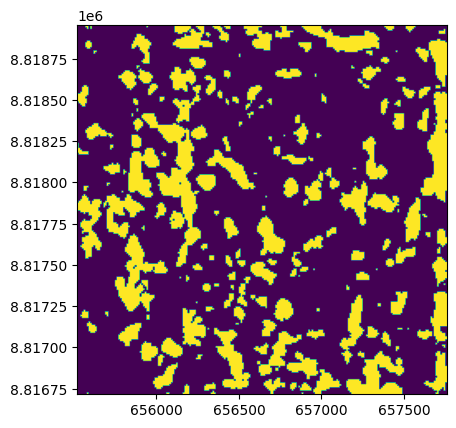

Prediction mosaic saved to: /content/working/zindi_best_model_20241028_50m_lr0005/aoi_2021_04_prediction_mosaic.tif


In [117]:
# Collect prediction file paths from the tiles GeoDataFrame
prediction_files = tiles['prediction_file'].tolist()

# Open prediction rasters using rasterio
prediction_datasets = [rasterio.open(file) for file in prediction_files]

# Merge prediction rasters into a single array
mosaic, out_transform = merge(prediction_datasets)

# Update metadata for the mosaic
out_meta = prediction_datasets[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "count": 1  # Single band for predictions
})

# Save the mosaic as a GeoTIFF file
output_predictions_mosaic = os.path.join(f"{working_path}/{model_name}", f"aoi_{aoi_name}_prediction_mosaic.tif")
with rasterio.open(output_predictions_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)

# Visualize the mosaic
show(mosaic, transform=out_transform)

print(f"Prediction mosaic saved to: {output_predictions_mosaic}")

# Visualize Predictions on the satellite image

In [118]:
image = rio.open(tif_file_subset)
predictions = rio.open(output_predictions_mosaic)

# Read the predictions data
pred_data = predictions.read(1)  # Read the first band

# Create a mask where only pixels with a value of 1 are kept
masked_pred_data = np.ma.masked_where(pred_data != 1, pred_data)

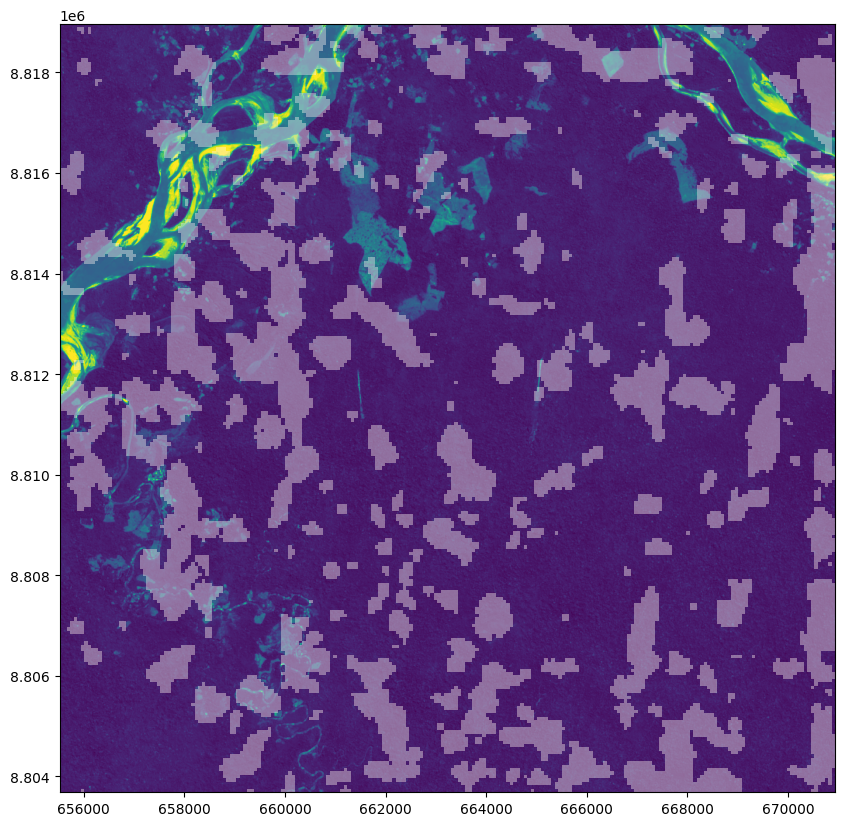

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))

# Display the base image using imshow
show(image, ax=ax)  # Adjust cmap if needed

# Get the extent of the image
image_extent = ax.get_images()[0].get_extent()

# Display the masked prediction data with transparency on top
show(
    masked_pred_data,
    ax=ax,
    alpha=0.4,
    cmap="Reds",
    extent=image_extent  # Use the image extent for proper alignment
)

plt.show()

# Convert predictions mosaic raster to CSV

In [44]:
# Open the binary raster file
with rasterio.open(output_predictions_mosaic) as src:
    # Read the raster data
    data = src.read(1)

    # Get the indices where the raster has non-zero values (label=1)
    rows, cols = (data == 1).nonzero()

    # Get the indices where the raster has non-zero values (label=1)
    rows, cols = (data == 1).nonzero()

    # Format aoi name to match sample sabmission file provided by Zindi
    aoi_name_zindi = aoi_name.replace('20', '')

    # Format row and column indices into 'tile_row_column' and create the 'label' column
    tile_row_column = [f"Tileaoi_{aoi_name_zindi}_{row}_{col}" for row, col in zip(rows, cols)]
    labels = [1] * len(tile_row_column)

    # Create DataFrame with specified column names
    df = pd.DataFrame({
        "tile_row_column": tile_row_column,
        "label": labels
    })

# Save DataFrame to CSV
df.to_csv(f"{working_path}/{model_name}/aoi_{aoi_name}_labels.csv", index=False)
print("CSV file created")

CSV file created
